<a href="https://colab.research.google.com/github/Jiang15/fashion-gan/blob/master/Explore_Latent_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upgrade CUDA to 11.2
!sudo apt-get upgrade cuda
!apt --fix-broken install
# # Needed so plugins compile successfully
!pip install ninja

In [6]:
# link the google that models are saved
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cd /content/drive/MyDrive/fashion-gan/stylegan

/content/drive/MyDrive/fashion-gan/stylegan


In [30]:
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import PIL
import torch
import dnnlib
import legacy
import imageio
import json
import math
import pandas as pd
from projector import img_to_w
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from helpers import generate_w, generateZ_from_seed, generate_image_from_z, E

### Load trained model

In [9]:
network = "training_runs/00015-square_256_imgs-auto1-resumecustom/network-snapshot-000400.pkl"

In [10]:
# load generator
device = torch.device('cuda')
with dnnlib.util.open_url(network) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

### PCA for finding resonable direction

Generate N=5000 latent codes and apply PCA analysis to find meaningful directions (principle components)

In [11]:
seed = 0
z = generateZ_from_seed(seed, G)
w, img = generate_image_from_z(z, G)
# get N number of w
N = 5000
for seed in np.arange(1, N):
    z = generateZ_from_seed(seed, G)
    w_seed, img = generate_image_from_z(z, G)
    w = np.concatenate((w, w_seed), axis=0)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [12]:
pca = PCA()
pca.fit(w)

PCA()

In [13]:
vectors = pca.components_
variances = pca.explained_variance_ratio_
# np.save("out/vectors.npy", vectors)
# vectors = np.load('out/vectors.npy')

##### Image editing enabled by PCA
Now we explore the changes in different directions and layers.  
For example, in the first dierection, 0-4 controls the length of the sleeves, 7-14 controls the color.

In [14]:
def visualize_two_magnititue(G, vectors, direction_ind, layers, mag):
  """
  visulize meaning of ind'th vector in 'layers' by moving along the direction with magtitude(mag)
  """
    fig, axs = plt.subplots(len(mag[0]), len(mag[0]), figsize=(3*len(mag[0]),3*len(mag[0])))
    seed = random.randint(1,100)
    seed = 85
    z = generateZ_from_seed(seed, G)
    w_origin = generate_w(z, G)
    # get original w
    print(seed)
    print(mag)
    for ind_x in range(len(mag[0])):
        for ind_y in range(len(mag[0])):
            # get modified w
            w_tmp = E(vectors, direction_ind[0], [mag[0][ind_x]], layers[0], w_origin.cpu().numpy())
            w_modify = E(vectors, direction_ind[1], [mag[1][ind_y]], layers[1], w_tmp.cpu().numpy())

            img_modify = generate_image_from_w(w_modify, G)

            if mag[0][ind_x] == 0 and mag[1][ind_y] == 0:
                rect = Rectangle((0,0),255,255,linewidth=2,edgecolor='g',facecolor='none')
                # Add the patch to the Axes
                axs[ind_x,ind_y].add_patch(rect)
            axs[ind_x,ind_y].imshow(img_modify)
            axs[ind_x,ind_y].axis('off')
    plt.savefig("result/pca" + str(seed) + ".png")

85
[[-4, -2, 0, 3, 5], [-4, -2, 0, 2, 7]]


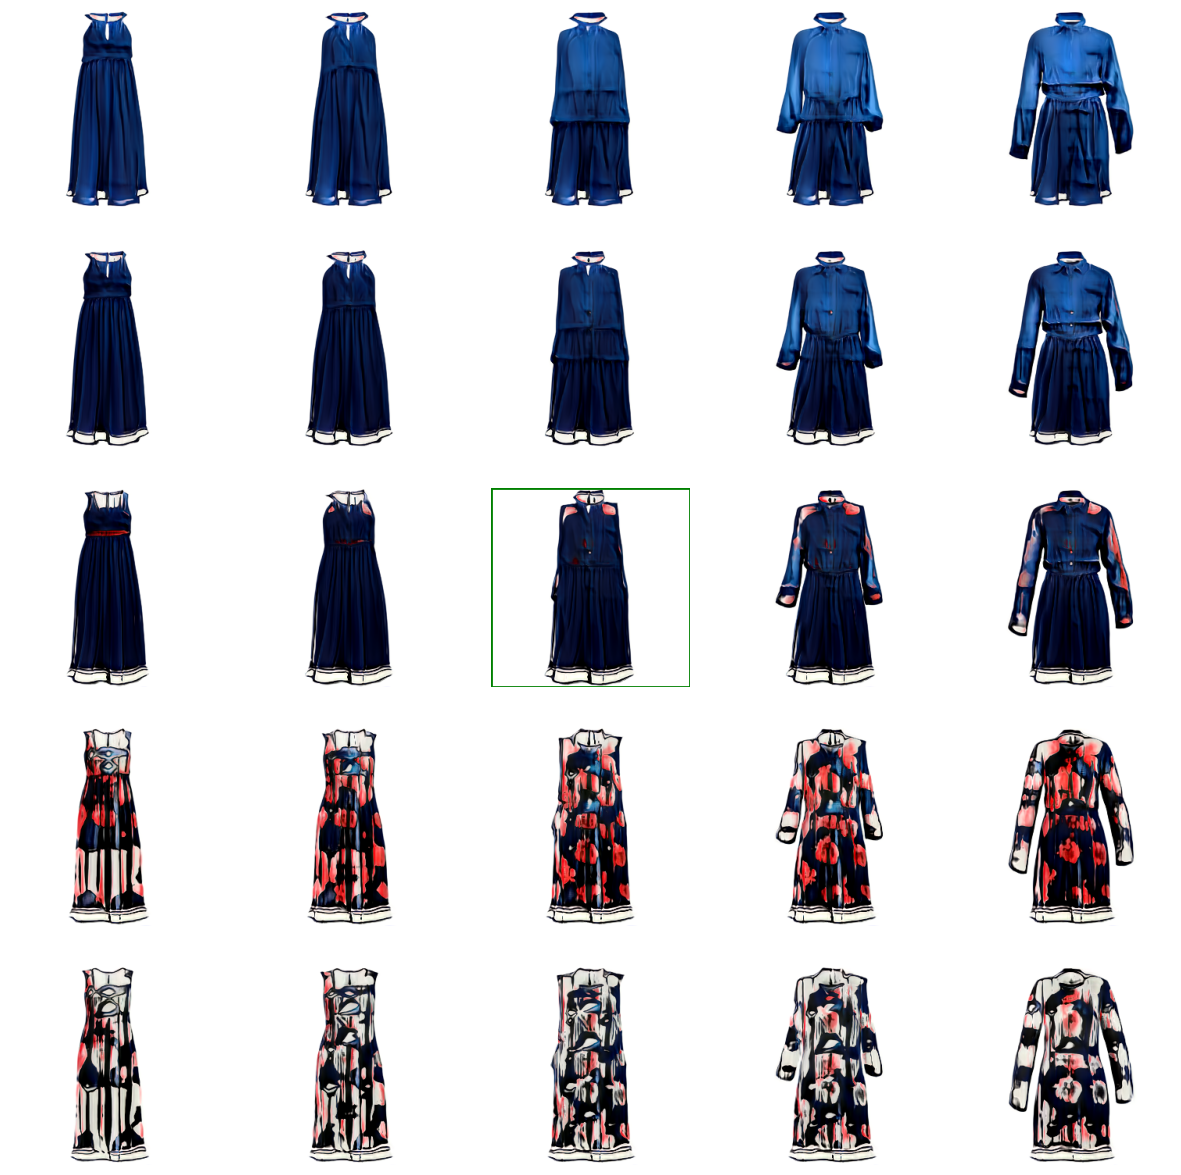

In [15]:
direction_ind = [[4], [0]]  # direction index
layers = [[np.arange(3,10,1)], [np.arange(0,4,1)]]  # layers for adding the vector
mag= [[-4, -2, 0, 3, 5], [-4, -2, 0, 2, 7]]
visualize_two_magnititue(G, vectors, direction_ind, layers, mag)

In [19]:
def visualize_magnititue(G, vectors,  direction_ind, layers, magnititude = np.arange(-10, 10, 3)):
  """
  visualize meaning of one direction of vector in ind'th directions by linearly moving the magnititude
  """
  fig, axs = plt.subplots(10, len(magnititude), figsize=(20, 40))
   # fig.suptitle("The "+ str(direction_ind[0]) + " component of PCA")
  for ind_x in range(10):
      seed = random.randint(1,100)
      z = generateZ_from_seed(seed, G)
      # get original w
      w_origin = generate_w(z, G)
      for ind_y, mag in enumerate(magnititude):
          # get modified w
          w_modify = E(vectors, direction_ind, [mag], layers, w_origin.cpu().numpy())
          img_modify = generate_image_from_w(w_modify, G)
          if mag == 0:
              rect = Rectangle((0,0),255,255,linewidth=2,edgecolor='g',facecolor='none')
              # Add the patch to the Axes
              axs[ind_x,ind_y].add_patch(rect)
          axs[ind_x,ind_y].imshow(img_modify)
          axs[ind_x,ind_y].axis('off')
          if ind_x ==0:
              axs[ind_x,ind_y].set_title(f"E({direction_ind[0]},{mag},({layers[0][0]+1},{layers[0][-1]+1}))")
  plt.savefig("result/pca/pca_direction" + str(direction_ind[0]) + str(layers[0][0]) + ".png")

##### PCA Result
We repetively visualize the meaning of first 10 principle components and found multiple semantically meaning directions. Those semantically meaningful direction is save in the json file.

id: n'th principle component.

layers: effective layers applied in synthesis network

effect: the meaning of the direction

mag: the effective range of the direction

In [26]:
# load the discovered meaningful direction
with open('static/output/dim_dic.txt') as fobj:
    dim_dic = json.load(fobj)
pd.DataFrame(dim_dic).T

,id,layers,mag,effect
0,0,"[0, 4]","[-10, 10]",sleeve
1,4,"[3, 9]","[-10, 10]",pattern
2,2,"[0, 7]","[-10, 10]","collar, hemline, width"
3,6,"[10, 14]","[-20, 20]","orange, blue"
4,0,"[10, 14]","[-30, 30]","Green, red"
5,7,"[10, 14]","[-40, 40]","dark, light"
6,9,"[0, 4]","[-10, 10]","hemline, collar"
7,8,"[3, 4]","[-20, 20]",waistline


### Visualize semantically meaningful Principle Components


In [31]:
def visualize_magnititue_img_in(G, vectors,  direction_ind, layers, magnititudes):
  """
  visualize the principle component with in-sample image
  """
  fig, axs = plt.subplots(1, 7,figsize=(21,3))
  seed = random.randint(1,100)

  z = generateZ_from_seed(seed, G)
  # get original w
  w_origin = generate_w(z, G)
  for ind_y, mag in enumerate(magnititudes):
      # get modified w
      w_modify = E(vectors, direction_ind, [mag], layers, w_origin.cpu().numpy())
      img_modify = generate_image_from_w(w_modify, G)
      if mag == 0:
          rect = Rectangle((0,0),255,255,linewidth=2,edgecolor='g',facecolor='none')
          # Add the patch to the Axes
          axs[ind_y].add_patch(rect)
      axs[ind_y].imshow(img_modify)
      axs[ind_y].axis('off')
      # if ind_x ==0:
      #     axs[ind_x,ind_y].set_title(f"E({direction_ind[0]},{mag},({layers[0][0]+1},{layers[0][-1]+1}))")
  plt.savefig("result/pca/pca_direction_in" + str(direction_ind[0]) + str(layers[0][0]) + ".png")

def visualize_magnititue_img_out(path, G, vectors,  direction_ind, layers, magnititudes):
  """
  visualize the principle component with out-of-sample image:
  Project the images to latent code and then apply changes to the latent code
  """
  fig, axs = plt.subplots(1, 7,figsize=(21,3))
  num_steps = 3000
  img = PIL.Image.open(p).convert('RGB')
  width, height = img.size
  if width != 256 or height != 256:

      result = PIL.Image.new("RGB", (256, 256), (255, 255, 255))

      # Resize image
      img.thumbnail((256, 256))
      # compute center
      position_x = math.floor((256 - img.width) / 2)
      position_y = math.floor((256 - img.height) / 2)
      # Paste image into center of background
      result.paste(img, (position_x, position_y))
      img = result
  w_origin = img_to_w(img, G, num_steps = num_steps, mode = "avg")

  ind_x=0
  for ind_y, mag in enumerate(magnititudes):
      # get modified w
      w_modify = E(vectors, direction_ind, [mag], layers, w_origin.cpu().numpy())
      img_modify = generate_image_from_w(w_modify, G)
      if mag == 0:
          rect = Rectangle((0,0),255,255,linewidth=2,edgecolor='g',facecolor='none')
          # Add the patch to the Axes
          axs[ind_y].add_patch(rect)
      axs[ind_y].imshow(img_modify)
      axs[ind_y].axis('off')
  plt.savefig("result/pca/pca_direction_out" + str(direction_ind[0]) + str(layers[0][0]) + ".png")

##### Principle component 1: Sleeve

56


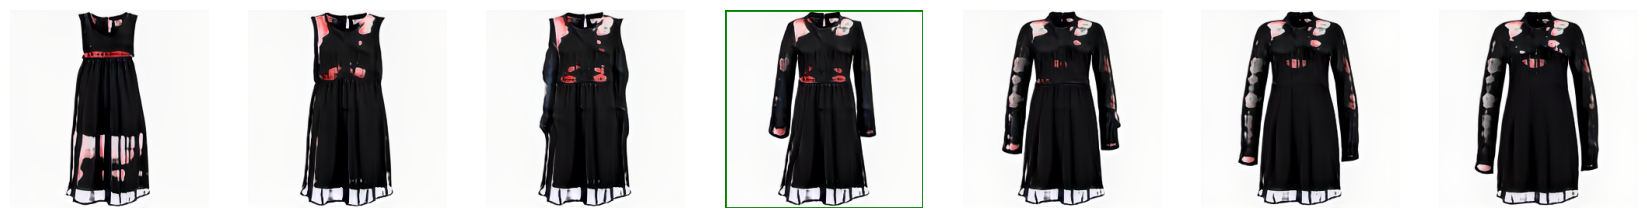

In [29]:
direction_ind = [0]  # direction index 67
layers = [np.arange(0,4,1)]  # layers for adding the vector
visualize_magnititue_img_in(G, vectors, direction_ind, layers, magnititudes = [-7,-3,-1.5,0,3,5,7])

model prepared
start sgd
tensor(0.0416, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0137, device='cuda:0', grad_fn=<MeanBackward0>)


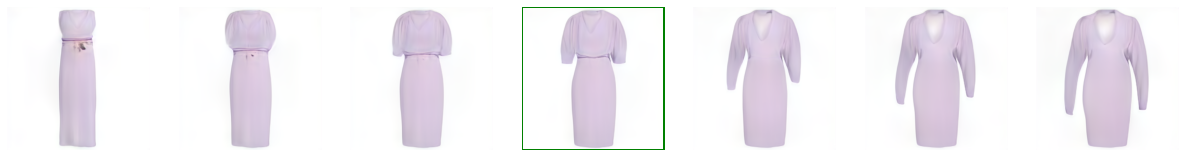

In [ ]:
direction_ind = [0]  # direction index
layers = [np.arange(0,4,1)]  # layers for adding the vector
p = "/content/drive/MyDrive/Colab Notebooks/Wei/feidegger/data/new_images/out_of_training_set_square/rich/lavendar_dress.png"
visualize_magnititue_img_out(p,G, vectors, direction_ind, layers, magnititudes = [-7,-3,-1.5,0,3,5,7])

##### Principle Component 2: Pattern

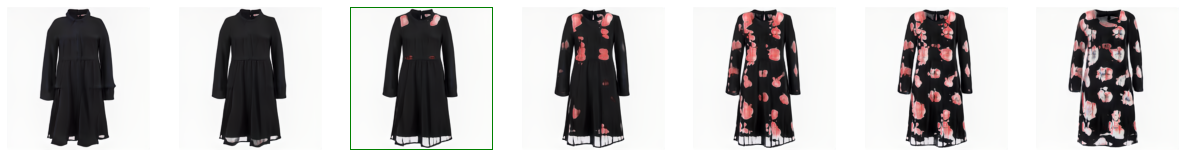

In [ ]:
direction_ind = [4]  # direction index 34 79 56 47
layers = [np.arange(3,9,1)]  # layers for adding the vector
visualize_magnititue_img_in(G, vectors, direction_ind, layers, magnititudes = [-3,-1.5,0,1,2, 3,5])

model prepared
start sgd
tensor(0.0942, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0386, device='cuda:0', grad_fn=<MeanBackward0>)


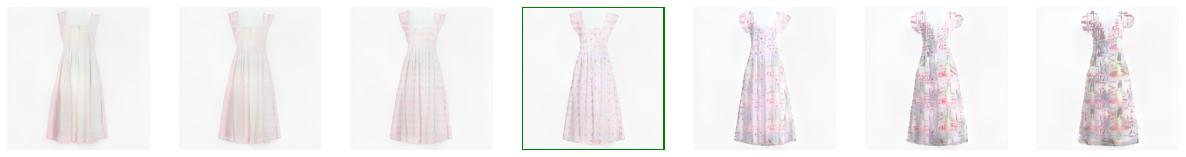

In [ ]:
direction_ind = [4]  # direction index 34 79 56 47
layers = [np.arange(3,9,1)]  # layers for adding the vector
p = "out_of_training_set_square/rich/white_pattern_dress.png" # your image path
visualize_magnititue_img_out(p, G, vectors, direction_ind, layers, magnititudes = [-5,-3,-1.5,0,3,5,7])

##### Principle Component 3: Collar

96


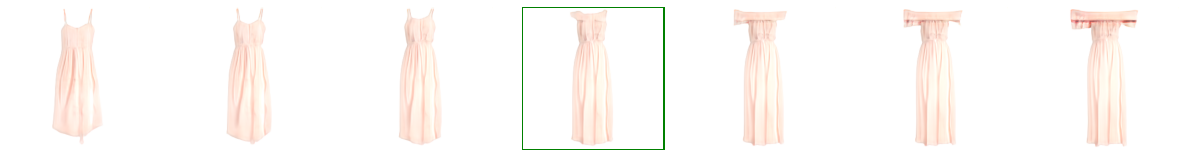

In [ ]:
direction_ind = [2]  # direction index 34 79 56 47
layers = [np.arange(0,7,1)]  # layers for adding the vector
visualize_magnititue_img_in(G, vectors, direction_ind, layers, magnititudes = [-5, -3,-1.5,0,1, 1.5,2.5])

model prepared
start sgd
tensor(0.0990, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2858, device='cuda:0', grad_fn=<MeanBackward0>)


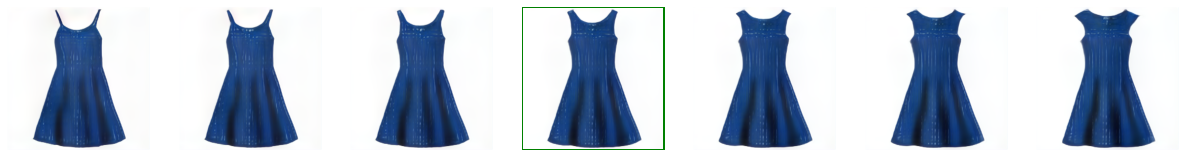

In [ ]:
direction_ind = [2]  # direction index 34 79 56 47
layers = [np.arange(0,7,1)]  # layers for adding the vector
p = "out_of_training_set_square/rich/blue_polkadot_dress.png"
visualize_magnititue_img_out(p, G, vectors, direction_ind, layers, magnititudes = [-3,-2,-1,0,1, 1.5, 2.5])

Principle Component 3: Waistline

47


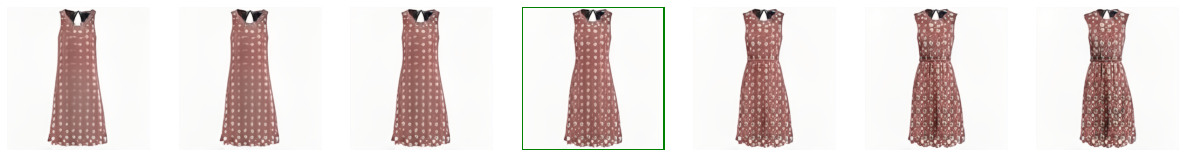

In [ ]:
direction_ind = [8]  # direction index 34 79 56 47
layers = [np.arange(3,4,1)]  # layers for adding the vector
p = "out_of_training_set_square/rich/blue_polkadot_dress.png"
visualize_magnititue_img_in(G, vectors, direction_ind, layers, magnititudes = [-15,-10,-5,0, 5, 10, 15])

model prepared
start sgd
tensor(0.0767, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0256, device='cuda:0', grad_fn=<MeanBackward0>)


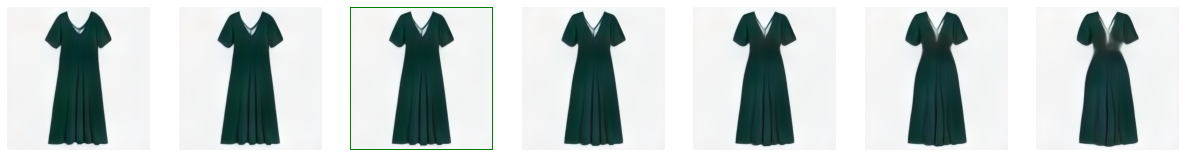

In [ ]:
direction_ind = [8]  # direction index 34 79 56 47
layers = [np.arange(3,4,1)]  # layers for adding the vector
p = "/content/drive/MyDrive/Colab Notebooks/Wei/feidegger/data/new_images/out_of_training_set_square/rich/green_dress.png"
visualize_magnititue_img_out(p,G, vectors, direction_ind, layers, magnititudes = [-15,-7,0, 5, 10, 15, 20])

##### Principle Component 5: Color

22


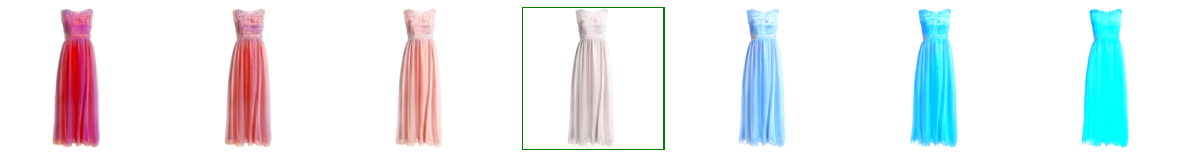

In [ ]:
direction_ind = [6]  # direction index 34 79 56 47
layers = [np.arange(10,14,1)]  # layers for adding the vector
p = "out_of_training_set_square/rich/blue_polkadot_dress.png"
visualize_magnititue_img_in(G, vectors, direction_ind, layers, magnititudes = [-15,-10,-5,0, 5, 10, 15])

model prepared
start sgd
tensor(0.0824, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0392, device='cuda:0', grad_fn=<MeanBackward0>)


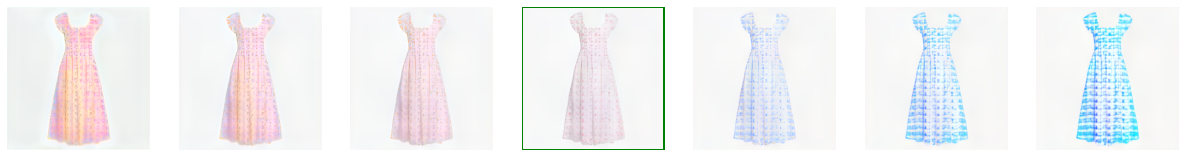

In [ ]:
direction_ind = [6]  # direction index 34 79 56 47
layers = [np.arange(10,14,1)]  # layers for adding the vector
p = "/content/drive/MyDrive/Colab Notebooks/Wei/feidegger/data/new_images/out_of_training_set_square/rich/white_pattern_dress.png"
visualize_magnititue_img_out(p, G, vectors, direction_ind, layers, magnititudes = [-15,-10,-5,0, 5, 10, 15])

##### Principle Component 6: Darkness

13


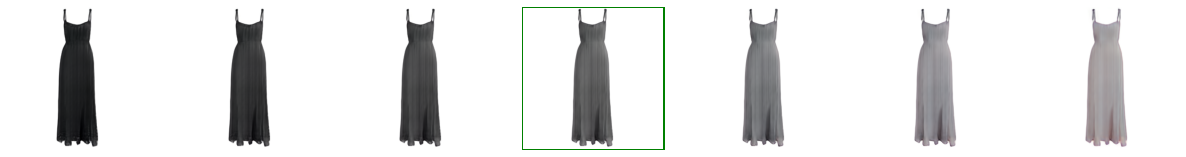

In [ ]:
direction_ind = [7]  # direction index 34 79 56 47
layers = [np.arange(10,14,1)]  # layers for adding the vector
p = "out_of_training_set_square/rich/blue_polkadot_dress.png"
visualize_magnititue_img_in(G, vectors, direction_ind, layers, magnititudes = [-20,-10,-5,0, 5, 10, 20])

model prepared
start sgd
tensor(0.0626, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0421, device='cuda:0', grad_fn=<MeanBackward0>)


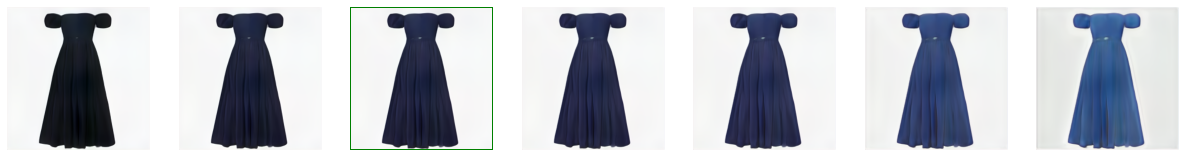

In [ ]:
direction_ind = [7]  # direction index 34 79 56 47
layers = [np.arange(10,14,1)]  # layers for adding the vector
p = "out_of_training_set_square/rich/blue_sleeves_dress.png"
visualize_magnititue_img_out(p, G, vectors, direction_ind, layers, magnititudes = [-15,-5,0, 5, 10, 20, 30])

##### Principle Component 7: Hemline

33


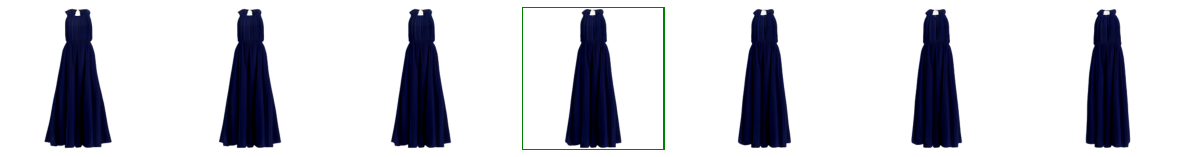

In [ ]:
direction_ind = [9]  # direction index 34 79 56 47
layers = [np.arange(0, 4,1)]  # layers for adding the vector
p = "out_of_training_set_square/rich/blue_polkadot_dress.png"
visualize_magnititue_img_in(G, vectors, direction_ind, layers, magnititudes = [-10,-5,-3,0, 3, 5, 10])

model prepared
start sgd
tensor(0.0670, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0301, device='cuda:0', grad_fn=<MeanBackward0>)


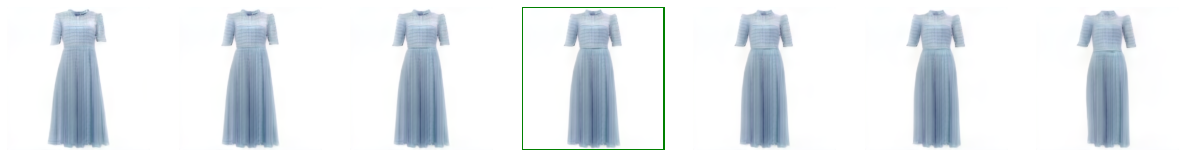

In [ ]:
direction_ind = [9]  # direction index 34 79 56 47
layers = [np.arange(0, 4,1)]  # layers for adding the vector
p = "/content/drive/MyDrive/Colab Notebooks/Wei/feidegger/data/new_images/out_of_training_set_square/rich/blue_frilly_dress.png"
visualize_magnititue_img_out(p, G, vectors, direction_ind, layers, magnititudes = [-10,-5,-3,0, 3, 5, 10])

##### Principle Component 8: V-Neck

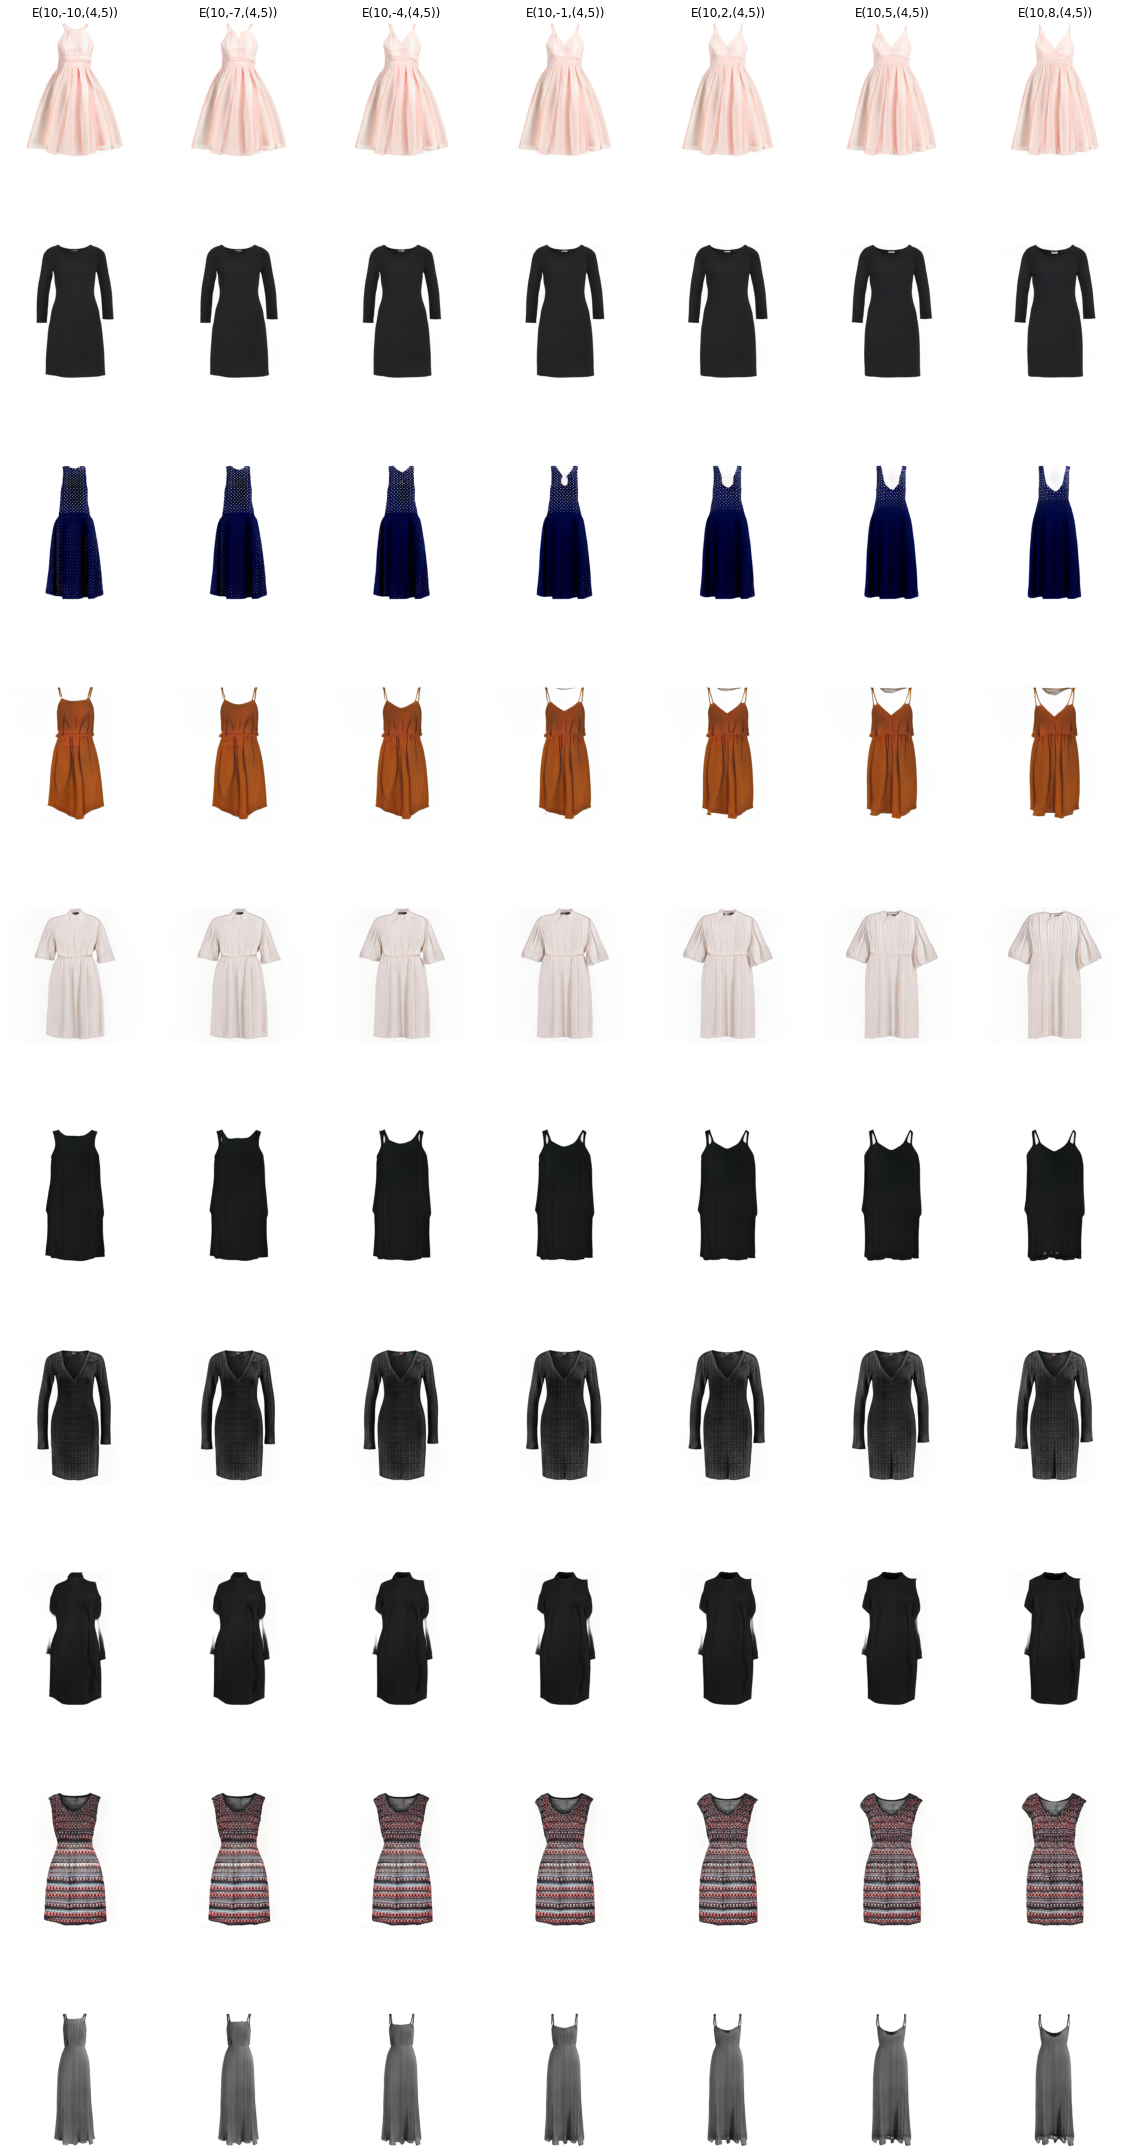

In [ ]:
direction_ind = [10]  # direction index
layers = [np.arange(3,5,1)]  # layers for adding the vector
visualize_magnititue(G, vectors, direction_ind, layers)